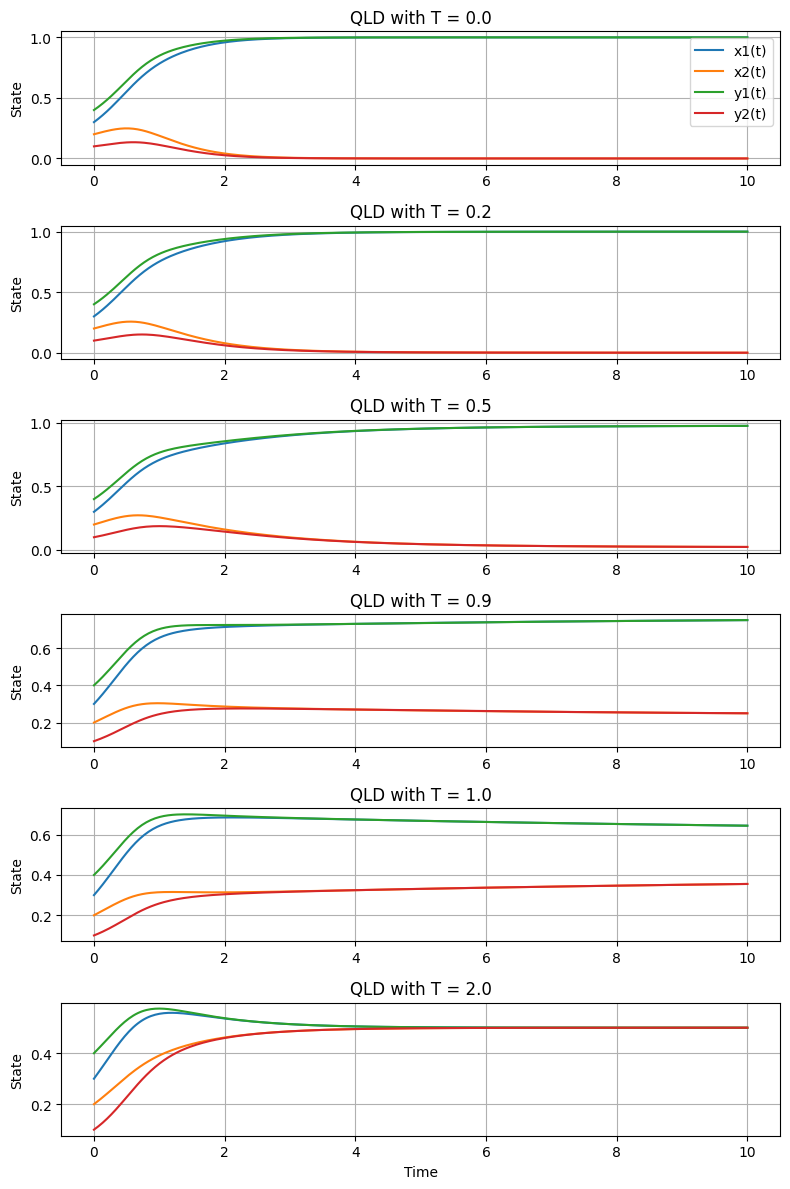

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def qlearning_system(state, t, T):
    """
    state = [x1, x2, y1, y2]
    Returns [dx1, dx2, dy1, dy2]
    """
    x1, x2, y1, y2 = state
    
    eps = 1e-10
    x1 = max(x1, eps)
    x2 = max(x2, eps)
    y1 = max(y1, eps)
    y2 = max(y2, eps)
    
    dx1 = x1*(6*y1 - 6*x1*y1 - 4*x2*y1 - 2*x2*y2 
              + T*x2*np.log(x2/x1))
    dx2 = x2*(4*y1 + 2*y2 - 6*x1*y1 - 4*x2*y1 - 2*x2*y2
              + T*x1*np.log(x1/x2))
    dy1 = y1*(6*x1 - 6*x1*y1 - 4*x1*y2 - 2*x2*y2
              + T*y2*np.log(y2/y1))
    dy2 = y2*(4*x1 + 2*x2 - 6*x1*y1 - 4*x1*y2 - 2*x2*y2
              + T*y1*np.log(y1/y2))
    return [dx1, dx2, dy1, dy2]


# Values of T to try
T_values = [0.0, 0.2, 0.5, 0.9, 1.0, 2.0]

# Time range
t = np.linspace(0, 10, 300)

# Initial condition (strictly positive to avoid log(0))
init_state = [0.3, 0.2, 0.4, 0.1]

# Create one figure for all subplots
plt.figure(figsize=(8, 12)) 

for i, T in enumerate(T_values, start=1):
    sol = odeint(qlearning_system, init_state, t, args=(T,))
    x1_sol = sol[:, 0]
    x2_sol = sol[:, 1]
    y1_sol = sol[:, 2]
    y2_sol = sol[:, 3]
    
    # Create a subplot in a column of length(T_values)
    plt.subplot(len(T_values), 1, i)
    plt.plot(t, x1_sol, label='x1(t)')
    plt.plot(t, x2_sol, label='x2(t)')
    plt.plot(t, y1_sol, label='y1(t)')
    plt.plot(t, y2_sol, label='y2(t)')
    plt.title(f'QLD with T = {T}')
    plt.ylabel('State')
    plt.grid(True)
    if i == 1:
        plt.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

/var/folders/7b/vp67hkx169q21m1g8l1_vpp40000gn/T/ipykernel_11519/3037766164.py:45: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system, guess)
/var/folders/7b/vp67hkx169q21m1g8l1_vpp40000gn/T/ipykernel_11519/3037766164.py:85: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(rp[0], rp[1], 'ko', markersize=8, color='red')


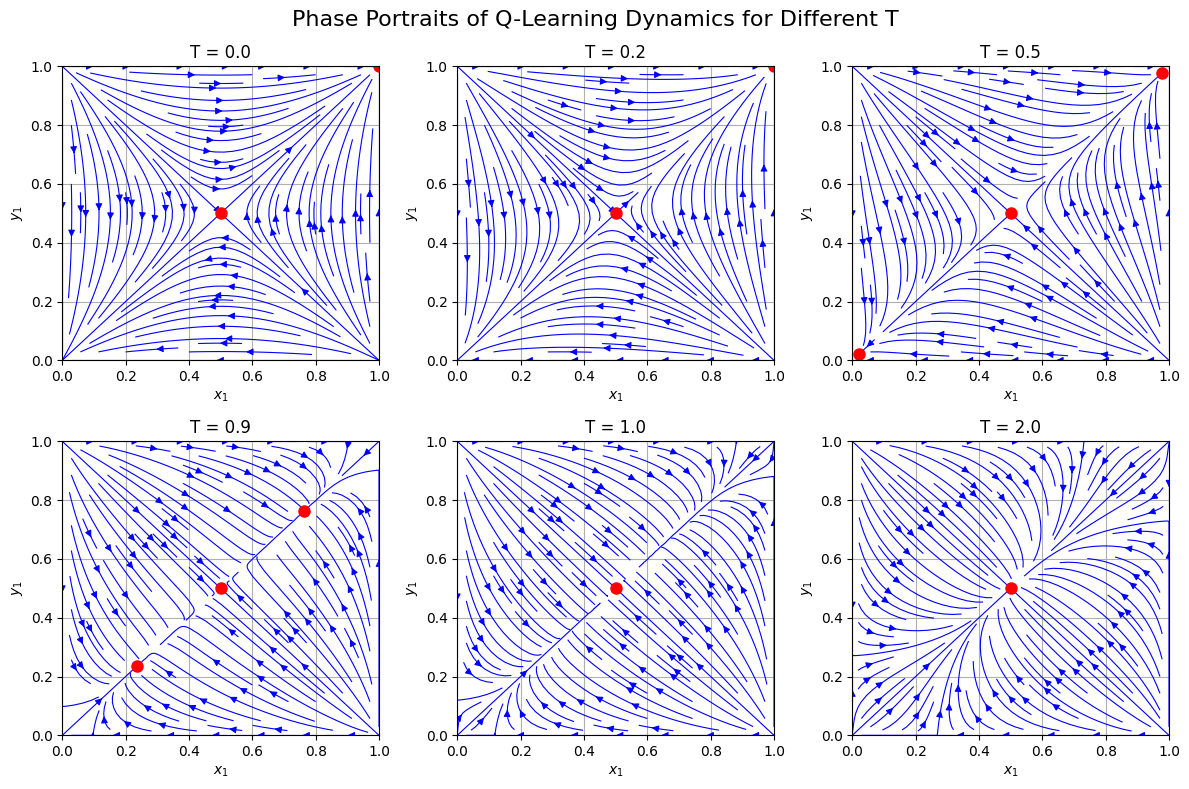

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def qld_2x2_field(xy, T):
    """
    xy = (x1,y1), with x2=1-x1, y2=1-y1.
    Return (dx1, dy1) from the Q-Learning ODE.
    """
    x1, y1 = xy
    x2 = 1.0 - x1
    y2 = 1.0 - y1

    # Avoid log(0) if x1=0, etc.:
    eps = 1e-12
    x1 = max(x1, eps)
    x2 = max(x2, eps)
    y1 = max(y1, eps)
    y2 = max(y2, eps)

    # Q-Learning formula for dx1, dy1
    dx1 = x1*(6*y1 - 6*x1*y1 - 4*x2*y1 - 2*x2*y2
              + T*x2*np.log(x2/x1))

    dy1 = y1*(6*x1 - 6*x1*y1 - 4*x1*y2 - 2*x2*y2
              + T*y2*np.log(y2/y1))

    return dx1, dy1

def compute_rest_points(T):
    """
    Find rest points of the Q-Learning Dynamics for a given T.
    Returns a list of distinct solutions in [0,1]x[0,1].
    """
    def system(variables):
        x1, y1 = variables
        dx1, dy1 = qld_2x2_field((x1, y1), T)
        return [dx1, dy1]

    # Several initial guesses to find up to 3 solutions:
    guesses = [(0.1, 0.1), (0.5, 0.5), (0.9, 0.9)]
    rest_points = []
    
    for guess in guesses:
        sol = fsolve(system, guess)
        # Check if the solution is valid (in [0,1]^2)
        # and if it's new (not too close to an already found point).
        if (0 <= sol[0] <= 1 and 0 <= sol[1] <= 1 
            and not any(np.allclose(sol, rp, atol=1e-4) for rp in rest_points)):
            rest_points.append(sol)
    
    return np.array(rest_points)

def plot_phase_portrait_for_T(ax, T, N=50):
    """
    Plot a streamplot (vector field) of Q-Learning ODE at T,
    and mark all rest points with black dots.
    """
    xs = np.linspace(0, 1, N)
    ys = np.linspace(0, 1, N)
    XX, YY = np.meshgrid(xs, ys)
    UU = np.zeros_like(XX)
    VV = np.zeros_like(YY)

    # Compute the vector field on a grid:
    for i in range(N):
        for j in range(N):
            x1 = XX[i, j]
            y1 = YY[i, j]
            dx1, dy1 = qld_2x2_field((x1, y1), T)
            UU[i, j] = dx1
            VV[i, j] = dy1

    # Plot the streamlines
    ax.streamplot(XX, YY, UU, VV, color='blue', linewidth=0.8, density=1.2)

    # Find rest points (no stability classification)
    rest_points = compute_rest_points(T)

    # Plot each rest point as a black dot
    for rp in rest_points:
        ax.plot(rp[0], rp[1], 'ko', markersize=8, color='red')

    ax.set_title(f"T = {T}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$y_1$")
    ax.grid(True)

def main():

    T_values = [0.0, 0.2, 0.5, 0.9, 1.0, 2.0]

    fig, axes = plt.subplots(2, 3, figsize=(12,8))

    for idx, T in enumerate(T_values):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        plot_phase_portrait_for_T(ax, T, N=50)

    fig.suptitle("Phase Portraits of Q-Learning Dynamics for Different T", fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

/var/folders/7b/vp67hkx169q21m1g8l1_vpp40000gn/T/ipykernel_67200/590860609.py:7: RuntimeWarning: invalid value encountered in log
  return (4*x - 2)/T - np.log(x/(1-x))
/var/folders/7b/vp67hkx169q21m1g8l1_vpp40000gn/T/ipykernel_67200/590860609.py:28: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(f, guess, args=(T,))


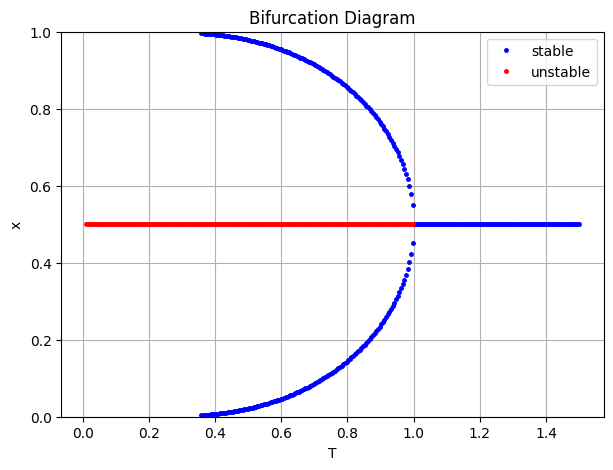

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def f(x, T):
    """ The 'flow' function. Fixed points satisfy f(x,T)=0. """
    return (4*x - 2)/T - np.log(x/(1-x))

def df_dx(x, T):
    """ Derivative of f with respect to x. 
        Negative => stable, Positive => unstable.
    """
    return 4/T - (1/x + 1/(1-x))

# Parameter sweep
T_values = np.linspace(0.01, 1.5, 300)

stable_pts = []   
unstable_pts = []  

for T in T_values:
    # We'll try multiple initial guesses to find all real solutions in (0,1).
    guesses = [0.01, 0.3, 0.5, 0.7, 0.99]
    solutions = []
    
    for guess in guesses:
        try:
            sol = fsolve(f, guess, args=(T,))
            x_sol = sol[0]
            # Check feasibility: x in (0,1) and f ~ 0
            if 0 < x_sol < 1 and abs(f(x_sol, T)) < 1e-7:
                # Avoid duplicates if they're very close
                if not any(abs(x_sol - s) < 1e-4 for s in solutions):
                    solutions.append(x_sol)
        except:
            pass
    
    # Check stability for each solution
    for x_sol in solutions:
        stability_indicator = df_dx(x_sol, T)
        if stability_indicator < 0:
            stable_pts.append((T, x_sol))
        else:
            unstable_pts.append((T, x_sol))

# Convert to arrays
stable_pts   = np.array(stable_pts)
unstable_pts = np.array(unstable_pts)

plt.figure(figsize=(7,5))

# Plot stable (blue) and unstable (red) solutions
if len(stable_pts)>0:
    plt.plot(stable_pts[:,0], stable_pts[:,1], 'b.', label='stable', ms=5)
if len(unstable_pts)>0:
    plt.plot(unstable_pts[:,0], unstable_pts[:,1], 'r.', label='unstable', ms=5)

plt.title(r"Bifurcation Diagram")
plt.xlabel("T")
plt.ylabel("x")
plt.ylim([0,1])
plt.grid(True)
plt.legend()
plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
/var/folders/7b/vp67hkx169q21m1g8l1_vpp40000gn/T/ipykernel_67200/3448747689.py:23: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Comparison of $\ln(x/(1-x))$ with $(4x - 2)/T$")


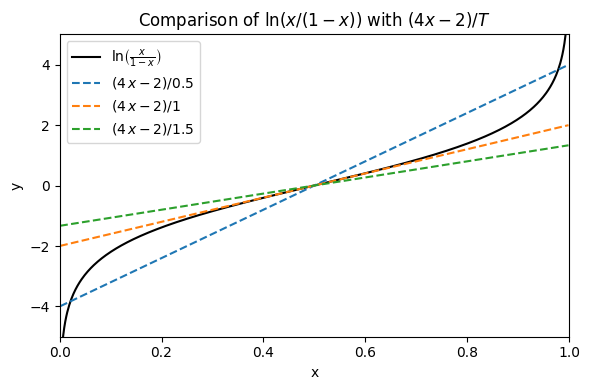

In [74]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0.001, 0.999, 500)
y_logistic = np.log(x/(1 - x))

plt.figure(figsize=(6,4))

# Plot the logistic-log function:
plt.plot(x, y_logistic, 'k-', 
         label=r'$\ln\!\left(\frac{x}{1-x}\right)$')

# Some T values for lines
T_values = [0.5, 1, 1.5]

for T in T_values:
    y_line = (4*x - 2)/T
    plt.plot(x, y_line, '--', 
             label=fr'$(4\,x - 2)/{T}$')

plt.xlabel('x')
plt.ylabel('y')
plt.title("Comparison of $\ln(x/(1-x))$ with $(4x - 2)/T$")
plt.legend()
plt.xlim(0,1)
plt.ylim(-5,5)

plt.tight_layout()
plt.show()

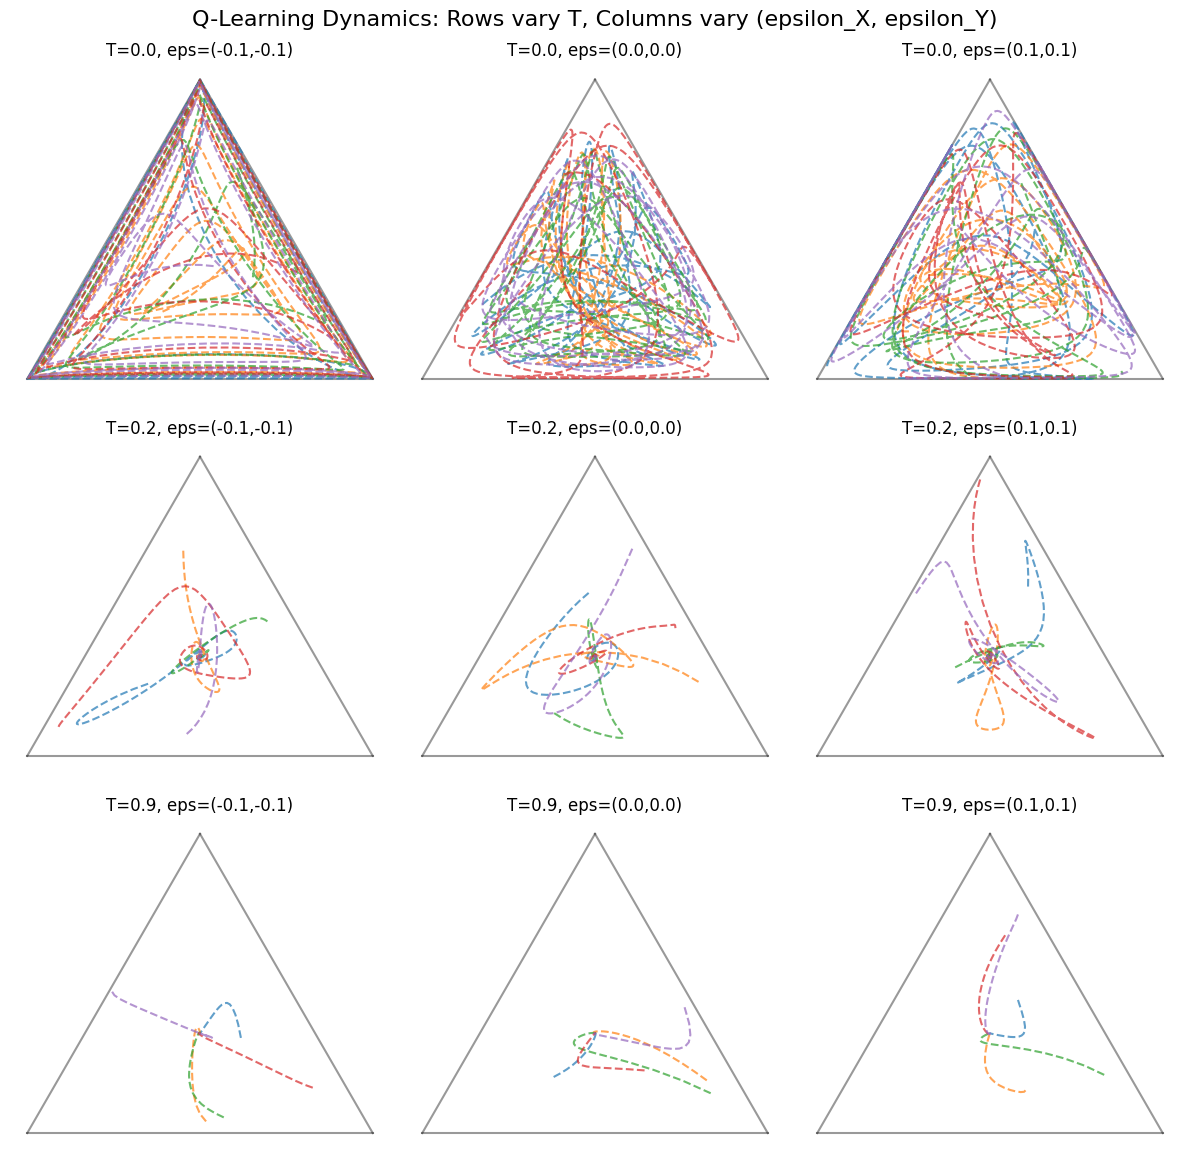

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def q_learning_dynamics(state, t, A, B, T):
    x = state[:3]
    y = state[3:]
    dx = np.zeros(3)
    dy = np.zeros(3)

    Ax = A @ y
    xAx = x @ Ax
    By = B.T @ x
    yBy = y @ By

    for i in range(3):
        dx[i] = x[i] * (Ax[i] - xAx + T * sum(x[j] * np.log(x[j] / x[i]) for j in range(3) if x[i] > 1e-12))
        dy[i] = y[i] * (By[i] - yBy + T * sum(y[j] * np.log(y[j] / y[i]) for j in range(3) if y[i] > 1e-12))

    return np.concatenate([dx, dy])

def define_game_matrix(epsilon_X, epsilon_Y):
    A = np.array([
        [ epsilon_X, -1,        1       ],
        [ 1,         epsilon_X, -1      ],
        [-1,         1,         epsilon_X]
    ])
    B = np.array([
        [ epsilon_Y,  1,       -1       ],
        [-1,         epsilon_Y, 1       ],
        [ 1,        -1,         epsilon_Y]
    ])
    return A, B

def plot_on_simplex_ax(ax, traj):
    proj = np.array([
        [-1 * np.cos(np.radians(30)),  np.cos(np.radians(30)),   0],
        [-1 * np.sin(np.radians(30)), -1 * np.sin(np.radians(30)), 1]
    ])

    ts = np.linspace(0, 1, 200)
    e1 = proj @ np.array([ts, 1 - ts, 0 * ts])
    e2 = proj @ np.array([0 * ts, ts, 1 - ts])
    e3 = proj @ np.array([ts, 0 * ts, 1 - ts])

    ax.plot(e1[0], e1[1], 'k-', alpha=0.4)
    ax.plot(e2[0], e2[1], 'k-', alpha=0.4)
    ax.plot(e3[0], e3[1], 'k-', alpha=0.4)

    for i in range(traj.shape[2]):
        path_3d = traj[:, :, i]
        path_2d = proj @ path_3d
        ax.plot(path_2d[0], path_2d[1], '--', alpha=0.7)

    ax.set_aspect('equal', 'box')
    ax.axis('off')

def main():
    T_values = [0.0, 0.2, 0.9]
    epsilon_combinations = [(-0.1, -0.1), (0.0, 0.0), (0.1, 0.1)]
    timesteps = np.linspace(0, 100, 500)

    fig, axes = plt.subplots(len(T_values), len(epsilon_combinations), figsize=(12, 12))
    fig.suptitle("Q-Learning Dynamics: Rows vary T, Columns vary (epsilon_X, epsilon_Y)", fontsize=16)

    for i, T in enumerate(T_values):
        for j, (epsX, epsY) in enumerate(epsilon_combinations):
            ax = axes[i, j]
            A, B = define_game_matrix(epsX, epsY)
            num_trajectories = 5
            all_sol = np.zeros((6, len(timesteps), num_trajectories))
            
            for k in range(num_trajectories):
                x0 = np.random.dirichlet([1, 1, 1])
                y0 = np.random.dirichlet([1, 1, 1])
                state0 = np.concatenate([x0, y0])
                sol = odeint(q_learning_dynamics, state0, timesteps, args=(A, B, T))
                all_sol[:, :, k] = sol.T
            
            plot_on_simplex_ax(ax, all_sol[:3, :, :])
            ax.set_title(f"T={T}, eps=({epsX},{epsY})")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()